In [6]:
!pip install sklearn-crfsuite
!pip install tabulate
!pip install nervaluate

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tabulate import tabulate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from nervaluate import Evaluator
from tqdm.auto import tqdm
import re

tqdm.pandas()

In [8]:
tag_name_pattern = re.compile(r"(B|I)-")

def map_seq(seq, dictionary):
    return [dictionary[elem] for elem in seq]

def plot_confusion_matricies(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)

    precision_cm = cm / np.sum(cm, axis=0)
    recall_cm = cm / np.sum(cm, axis=1)

    precision_cm = pd.DataFrame(np.flip(precision_cm, axis=0), columns=class_labels)
    recall_cm = pd.DataFrame(np.flip(recall_cm, axis=0), columns=class_labels)

    precision_cm = precision_cm.set_index(np.flip(class_labels)).fillna(0)
    recall_cm = recall_cm.set_index(np.flip(class_labels)).fillna(0)

    _, axs = plt.subplots(ncols=2, figsize=(22,8))
    axs[0].set_title("Precision per class")
    axs[1].set_title("Recall per class")

    sns.heatmap(precision_cm, annot=True, fmt=".2f", robust=True, cbar=False, ax=axs[0]);
    sns.heatmap(recall_cm, annot=True, fmt=".2f", robust=True, cbar=False, ax=axs[1]);

def plot_eval_result(results):
    keys = list(results.keys())
    #_, axs = plt.subplots(nrows=len(keys), ncols=2, figsize=(20,12))
    normalized_stats = ["f1", "recall", "precision"]
    absolute_stats = ["correct", "incorrect", "partial", "missed", "spurious", "possible", "actual"]
    for ind, key in enumerate(keys):
        fig, axs = plt.subplots(ncols=2, figsize=(20,3))
        fig.suptitle(key)
        stats = results[key]
        temp_df = pd.DataFrame(stats, index=[0], columns=stats.keys())
        #temp_df[absolute_stats] = temp_df[absolute_stats] / temp_df[absolute_stats].sum(axis=1).iloc[0]
        sns.barplot(data=temp_df[normalized_stats], palette="crest", ax=axs[0])
        sns.barplot(data=temp_df[absolute_stats], palette="crest", ax=axs[1])

In [9]:
data1 = pd.read_csv("/content/ner.csv", encoding = "ISO-8859-1", index_col=0, error_bad_lines=False)
data2 = pd.read_csv("/content/ner_dataset.csv", encoding="latin1")

<ipython-input-9-d425c7bc45b4>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data1 = pd.read_csv("/content/ner.csv", encoding = "ISO-8859-1", index_col=0, error_bad_lines=False)
Skipping line 281837: expected 25 fields, saw 34



In [10]:
chrs = ["\x85", "\x94"]
lengths = data2["Word"].apply(lambda x: len(x.split()))
data2 = data2[lengths == 1]
data2 = data2[data2["Word"].apply(lambda x: x not in chrs)]
data2 = data2.reset_index(drop=True)

In [11]:
first_words_inds = data2[data2["Sentence #"].notna()].index.to_list()
for i in tqdm(range(len(first_words_inds)-1)):
    data2["Sentence #"].loc[range(first_words_inds[i], first_words_inds[i+1])] = i
data2["Sentence #"].loc[range(first_words_inds[-1],data2["Sentence #"].shape[0])] = len(first_words_inds) - 1
data2 = data2.astype({"Sentence #": int, "Word": "string", "POS": "string", "Tag": "string"})

  0%|          | 0/47958 [00:00<?, ?it/s]

In [12]:
texts_df = data2[["Sentence #", "Word", "POS", "Tag"]].groupby(by="Sentence #").aggregate(lambda x: " ".join(x))
texts_df.columns = ["text", "pos seq", "tag seq"]

<ipython-input-13-c7778896f889>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=temp_df, x="pos", y="count", order=temp_df["pos"], palette="crest", ax=ax);


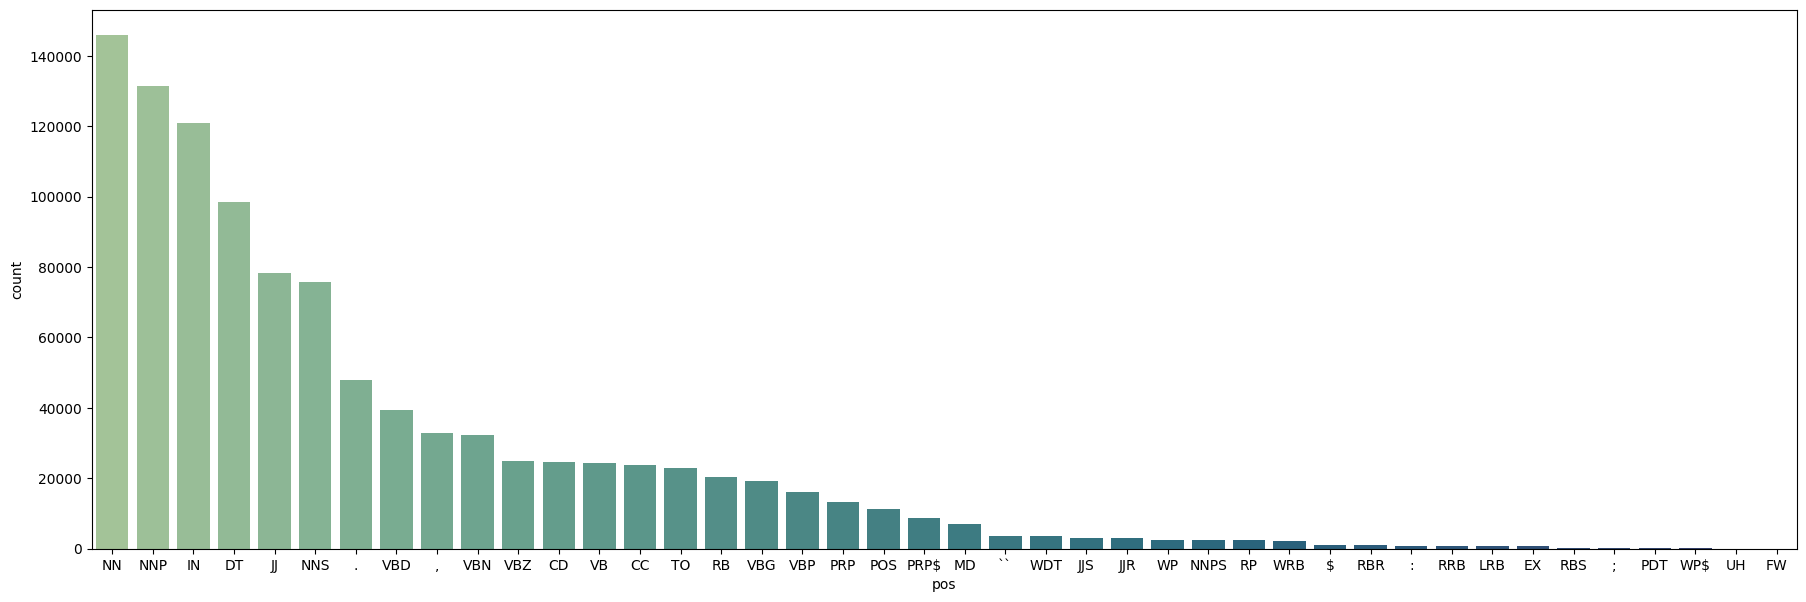

In [13]:
_, ax = plt.subplots(figsize=(22,7))
temp_df = pd.DataFrame(data2["POS"].value_counts().to_dict().items(), columns=["pos", "count"])
sns.barplot(data=temp_df, x="pos", y="count", order=temp_df["pos"], palette="crest", ax=ax);


<ipython-input-14-071ed19b0282>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=temp_df, x="tag", y="count", order=temp_df["tag"], palette="crest", ax=ax);


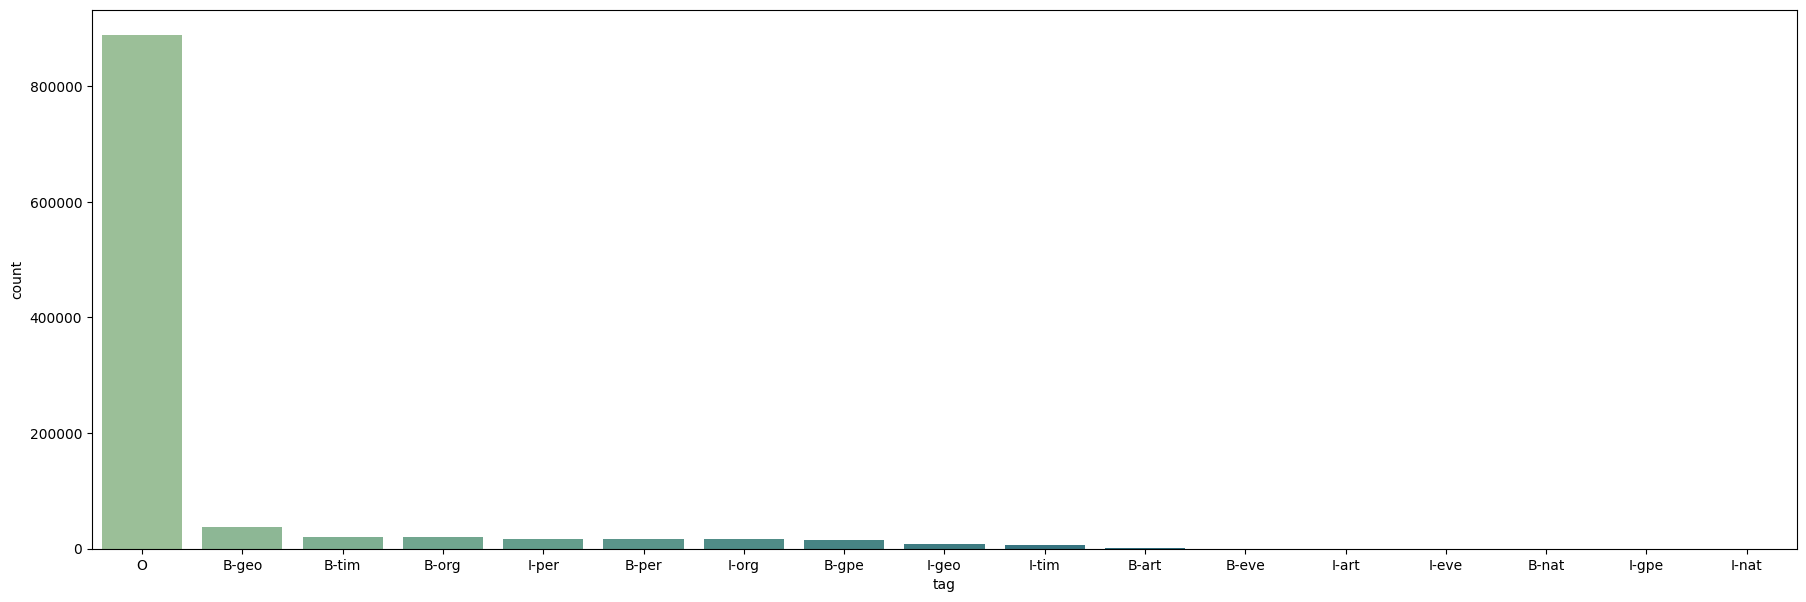

In [14]:
_, ax = plt.subplots(figsize=(22,7))
temp_df = pd.DataFrame(data2["Tag"].value_counts().to_dict().items(), columns=["tag", "count"])
sns.barplot(data=temp_df, x="tag", y="count", order=temp_df["tag"], palette="crest", ax=ax);

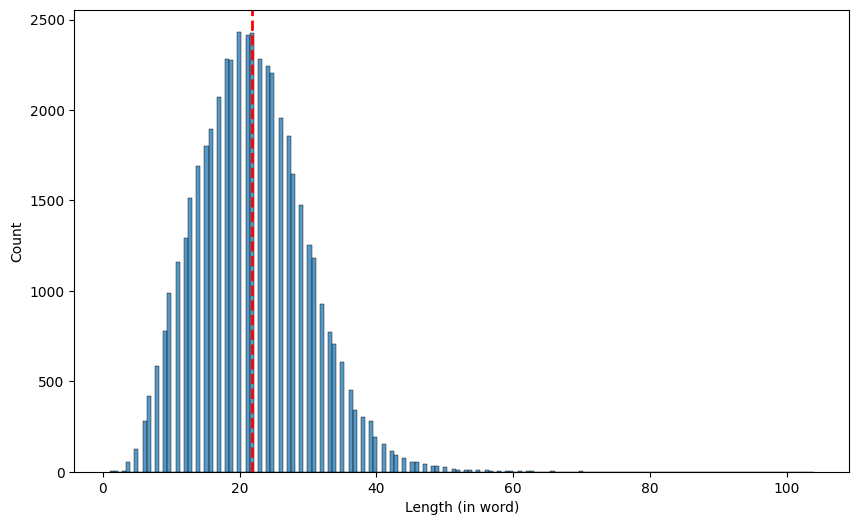

In [15]:
sentence_lengths = data2["Sentence #"].value_counts()
_, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel("Length (in word)")
sns.histplot(data=sentence_lengths, ax=ax)
ax.axvline(sentence_lengths.mean(), color='red', linestyle='dashed', linewidth=2);


In [16]:
print(f"Max sentence length (in words): {sentence_lengths.max()}")
print(f"Mean sentence length (in words): {sentence_lengths.mean()}")
print(f"Min sentence length (in words): {sentence_lengths.min()}")

Max sentence length (in words): 104
Mean sentence length (in words): 21.863800329448072
Min sentence length (in words): 1


In [17]:
sentence_length_treshold = 4
for ind in sentence_lengths[(sentence_lengths < sentence_length_treshold)].index:
    print(" ".join(data2[data2["Sentence #"] == ind]["Word"].to_list()))

It was .
George W. Bush
George W. Bush
Recep Tayyip Erdogan
Fifteen dollars .
John Garang
Bermet Akayeva
Thursday .
Janice Karpinski
John Garang
Questions ?
The
...


In [18]:
print(f"Vocabulary size: {data2['Word'].unique().shape[0]}")


Vocabulary size: 35175


<ipython-input-19-9882c69b391f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=temp_df.iloc[:topn], x="token", y="count", palette="crest", ax=ax);


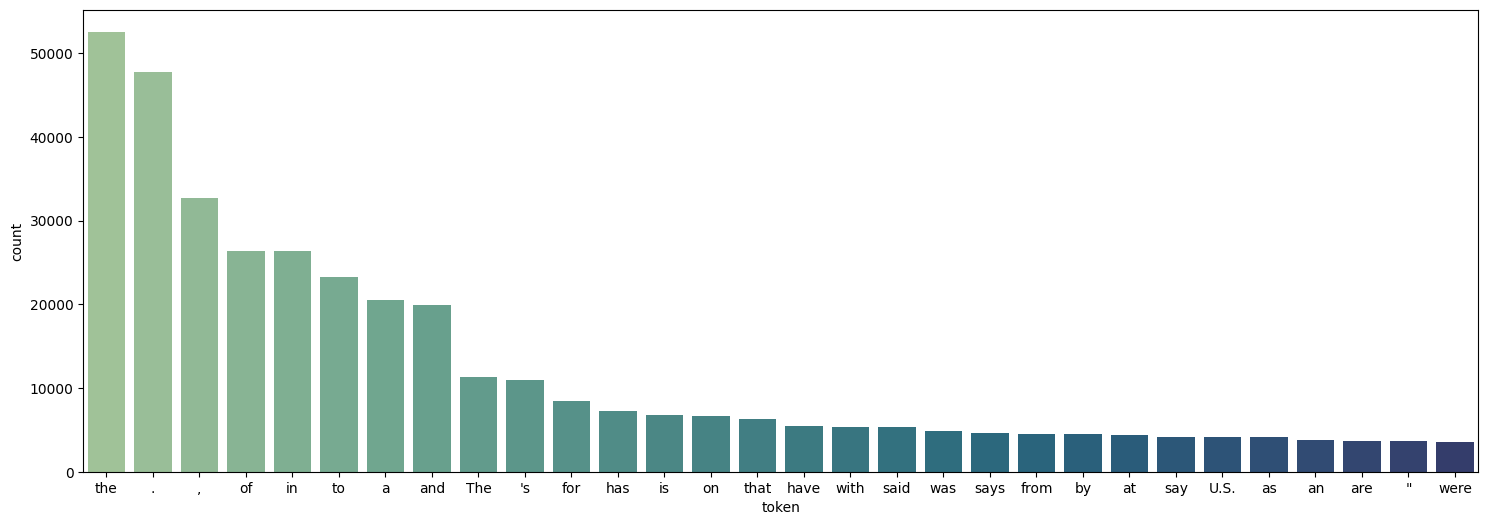

In [19]:
temp_df = pd.DataFrame(data2['Word'].value_counts().items(), columns=["token", "count"])
topn = 30
_, ax = plt.subplots(figsize=(18, 6))
sns.barplot(data=temp_df.iloc[:topn], x="token", y="count", palette="crest", ax=ax);

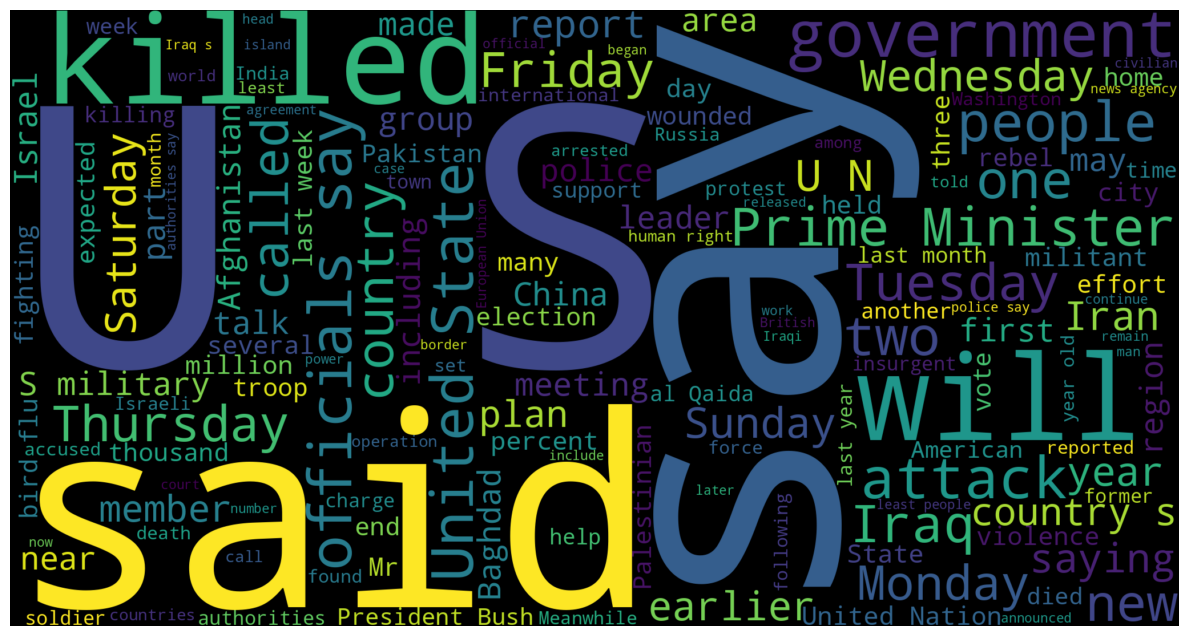

In [20]:
_, ax = plt.subplots(figsize=(16,8))
ax.axis("off")

wc_img = WordCloud(width=2048, height=1080, max_words=150).generate(" ".join(data2["Word"]))
ax.imshow(wc_img, interpolation="bilinear")

In [21]:
def find_frequent_n_gram(texts, ngramm_range, top_words_count=None, stopwords=None, lowercase=True, tokenizer=None):
    co = CountVectorizer(stop_words=stopwords, tokenizer=tokenizer, ngram_range=ngramm_range, lowercase=lowercase, max_features=top_words_count)
    counts = co.fit_transform(texts).sum(axis=0).flatten()
    counts = np.array(counts).flatten()
    n_grams = co.get_feature_names()
    df = pd.DataFrame(sorted(zip(n_grams, counts), key=lambda x:x[1], reverse=True), columns=["ngramm", "count"])
    return df

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

# Assuming find_frequent_n_gram uses CountVectorizer internally
# and returns the fitted CountVectorizer object

# Example:
def find_frequent_n_gram(text_data, ngramm_range, **kwargs):
    vectorizer = CountVectorizer(ngram_range=ngramm_range, **kwargs)
    X = vectorizer.fit_transform(text_data)
    # Optionally, you can return vectorizer to access get_feature_names() later
    return vectorizer

word_bi_grams = find_frequent_n_gram(texts_df["text"], ngramm_range=(2,2))
# Now you can access get_feature_names()
feature_names = word_bi_grams.get_feature_names_out()


In [25]:
feature_names

array(['00 000', '00 after', '00 local', ..., 'zwelinzima vavi',
       'zyazikov former', 'zydeco and'], dtype=object)

In [26]:
sent_without_ents = (texts_df["tag seq"].apply(lambda x: x.split()).apply(lambda x: len(set(x)) == 1 and "O" in x))
print(f"Sentences without any entity: {sent_without_ents.sum()}")

Sentences without any entity: 7042


In [27]:
texts_df[sent_without_ents]["text"]

Sentence #
3        Police put the number of marchers at 10,000 wh...
10       The step will allow the facility to operate at...
36       The provincial governor must still sign the bi...
38        Violators could be jailed for up to six months .
47        His driver and a tribal elder were also killed .
                               ...                        
47935        It is the organization 's largest operation .
47947    The change in leaders is believed to be indica...
47950    The report also says militants launch about 60...
47956    Two more landed in fields belonging to a nearb...
47957    They say not all of the rockets exploded upon ...
Name: text, Length: 7042, dtype: string

In [29]:
from sklearn.model_selection import train_test_split
from sklearn_crfsuite.metrics import flat_classification_report

In [30]:
class HMMTaggerTemplate():
    def __init__(self, states, observations):
        """Initialize HMM model with states and observations
        :param states: array with unique hidden states (list)
        :param observations: array with unique observations (list)
        """
        # add 'Unk' to handle unkown tokens
        self.states = states
        self.observations = [*observations, 'Unk']
        self.states_num = len(self.states)
        self.observations_num = len(self.observations)

        self.init_prob = np.zeros(shape=(1, self.states_num))
        self.transition_matrix = np.zeros(shape=(self.states_num,self.states_num))
        self.emission_matrix = np.zeros(shape=(self.states_num, self.observations_num))

        self.states_to_idx = {state:idx for idx, state in enumerate(self.states)}
        self.observations_to_idx = {obs:idx for idx, obs in enumerate(self.observations)}


    def fit(self, train_data):
        """Estimate initial probability vector, transition and emission matrices
        :param train_data: list of sentecnes where each sentence is represented by list of tuples (state, observation)

        Example: train_data = [[('O', 'Thousands'),
                                ('O', 'of'),
                                ('O', 'demonstrators'),
                                ('O', 'have'),
                                ('O', 'marched'),
                                ('O', 'through'),
                                ('B-geo', 'London')],
                               [('B-gpe', 'Iranian'),
                                ('O', 'officials'),
                                ('O', 'say'),
                                ('O', 'they'),
                                ('O', 'expect'),
                                ('O', 'to'),
                                ('O', 'get'),
                                ('O', 'access')]]

        """
        self.emission_matrix += 1 # smoothing
        c_final = np.zeros(shape=(1, self.states_num))

        for example in train_data:
          first_state_ind = self.states_to_idx[example[0][0]]
          last_state_ind = self.states_to_idx[example[-1][0]]
          last_obs_ind = self.observations_to_idx[example[-1][1]]

          self.init_prob[0, first_state_ind] += 1
          c_final[0, last_state_ind] += 1

          for ind in range(len(example)-1):
            curr_state_ind = self.states_to_idx[example[ind][0]]
            curr_obs_ind = self.observations_to_idx[example[ind][1]]
            next_state_ind = self.states_to_idx[example[ind+1][0]]

            self.transition_matrix[next_state_ind, curr_state_ind] += 1
            self.emission_matrix[curr_state_ind, curr_obs_ind] += 1

          self.emission_matrix[last_state_ind, last_obs_ind] += 1

        self.init_prob = self.init_prob / np.sum(self.init_prob)
        self.transition_matrix = (self.transition_matrix / (np.sum(self.transition_matrix, axis=0))).T
        self.emission_matrix = self.emission_matrix / np.sum(self.emission_matrix, axis=1).reshape(-1, 1)
        #return self


    def __viterbi(self, obs_sequence_indices):
        """Decode incoming sequence of observations into the most propable sequence of hidden states using Viterbi algorithm
        : param obs_sequence_indices: list of observations indices
        :return: list of hidden states indices
        """
        tmp = [0]*self.states_num

        delta = [tmp[:]]  # Compute initial state probabilities
        for i in range(self.states_num):
          delta[0][i] = self.init_prob[0,i] * self.emission_matrix[i, obs_sequence_indices[0]]

        phi = [tmp[:]]

        for obs in obs_sequence_indices[1:]:  # For all observations except the inital one
          delta_t = tmp[:]
          phi_t = tmp[:]
          for j in range(self.states_num):   # Following formula 33 in Rabiner'89
            tdelta = tmp[:]
            tphimax = -1.0
            for i in range(self.states_num):
              tphi_tmp = delta[-1][i] * self.transition_matrix[i,j]
              if (tphi_tmp > tphimax):
                tphimax = tphi_tmp
                phi_t[j] = i
              tdelta[i] = tphi_tmp * self.emission_matrix[j, obs]
            delta_t[j] = max(tdelta)
          delta.append(delta_t)
          phi.append(phi_t)

        # Backtrack the path through the states  (Formula 34 in Rabiner'89)
        #
        tmax = -1.0
        for i in range(self.states_num):
          if (delta[-1][i] > tmax):
            tmax = delta[-1][i]
            state_seq = [i]  # Last state with maximum probability

        phi.reverse()  # Because we start from the end of the sequence
        for tphi in phi[:-1]:
          state_seq.append(tphi[state_seq[-1]])
        return reversed(state_seq)


    def predict(self, obser_seq):
        """Decode observable sequences using Viterbi algorithm
        :param obser_seq: list of sentences where each sentence is represented by list of observations
        :return: list of the most probable hidden states

        Example: obser_seq = [['The','military','says','the','blast'],
                              ['The','attack','prompted','Scandinavian','monitors','overseeing','Sri','Lanka']]
        """

        result = []

        for seq in tqdm(obser_seq):
          obser_inds_seq = [self.observations_to_idx[token] for token in seq]
          state_ind_seq = list(self.__viterbi(obser_inds_seq))
          state_seq = [self.states[state_ind] for state_ind in state_ind_seq]
          result.append(state_seq)
        return result

In [31]:
texts = texts_df["text"].apply(lambda x: x.split())
tags = texts_df["tag seq"].apply(lambda x: x.split())
X_train, X_test, y_train, y_test = train_test_split(texts.to_numpy(), tags.to_numpy(), test_size=0.15, random_state=42)

In [32]:
ziped_train = []
for pair in np.stack((X_train, y_train), axis=1):
    ziped_train.append(np.stack((pair[1], pair[0]), axis=1))

In [33]:
states = data2["Tag"].unique().to_numpy()
observ = data2["Word"].unique().to_numpy()
hmm = HMMTaggerTemplate(states, observ)

In [34]:
hmm.fit(ziped_train)

In [35]:
y_pred = hmm.predict(X_test)


  0%|          | 0/7194 [00:00<?, ?it/s]

In [37]:
y_test_flat = list(itertools.chain.from_iterable(y_test))
y_pred_flat = list(itertools.chain.from_iterable(y_pred))

In [42]:
print(classification_report(y_test_flat, y_pred_flat, labels=states))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           O       0.98      0.99      0.99    132448
       B-geo       0.83      0.86      0.85      5777
       B-gpe       0.89      0.90      0.90      2349
       B-per       0.80      0.72      0.76      2562
       I-geo       0.76      0.68      0.72      1102
       B-org       0.78      0.60      0.68      2976
       I-org       0.72      0.76      0.74      2484
       B-tim       0.92      0.75      0.83      3065
       B-art       0.00      0.00      0.00        63
       I-art       0.00      0.00      0.00        45
       I-per       0.76      0.93      0.83      2589
       I-gpe       0.93      0.56      0.70        25
       I-tim       0.84      0.44      0.58       974
       B-nat       0.00      0.00      0.00        40
       B-eve       0.00      0.00      0.00        48
       I-eve       1.00      0.05      0.09        42
       I-nat       0.00      0.00      0.00         9

    accuracy              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<ipython-input-8-f996f21734b4>:9: RuntimeWarning: invalid value encountered in divide
  precision_cm = cm / np.sum(cm, axis=0)


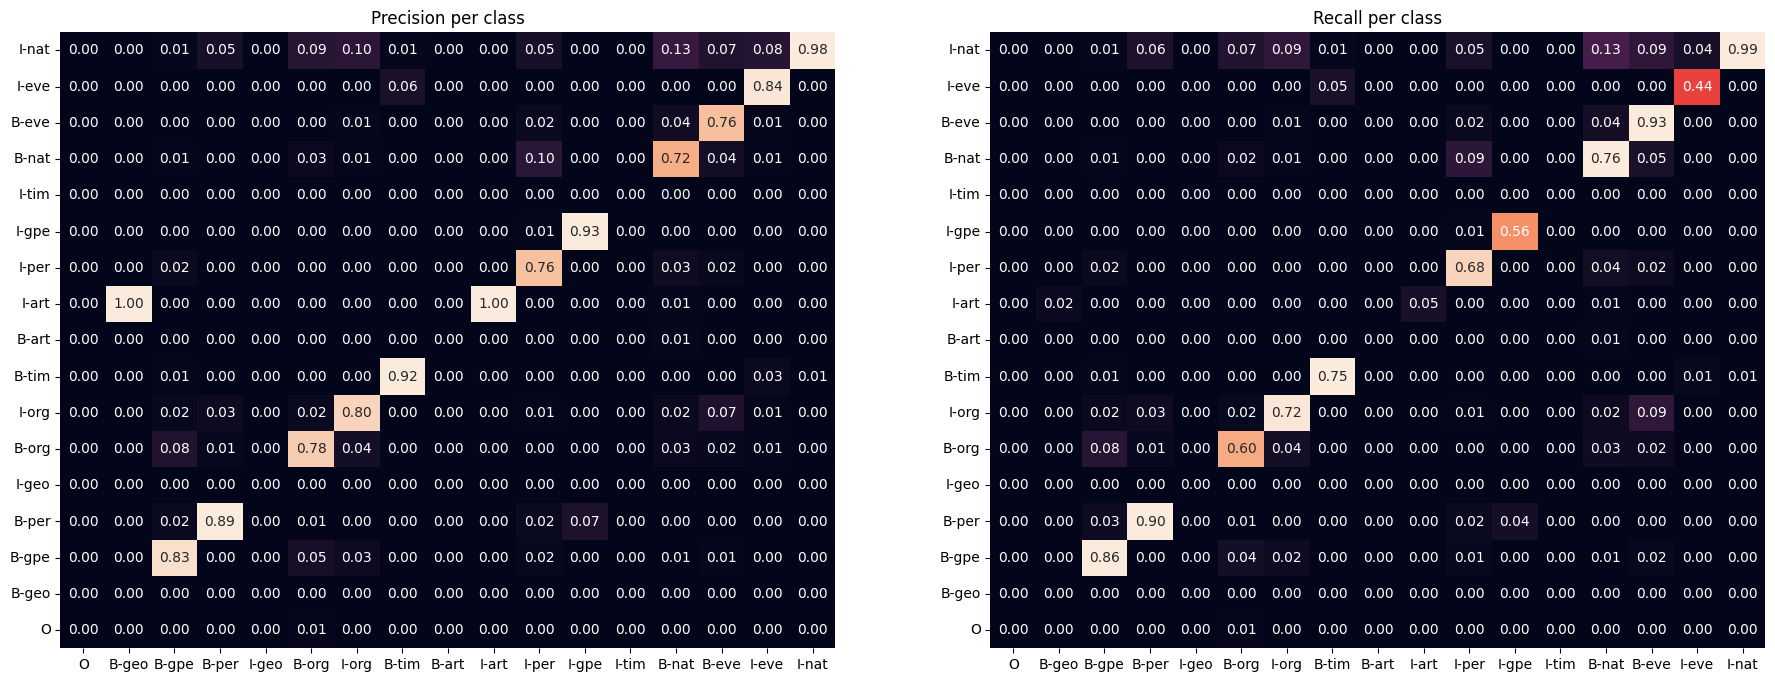

In [43]:
plot_confusion_matricies(y_test_flat, y_pred_flat, states)

In [44]:
ent_types = list(set([tag_name_pattern.sub("", tag) for tag in states]))

In [45]:
evaluator = Evaluator(y_test, y_pred, tags=ent_types, loader="list")

In [46]:
results, results_by_tag = evaluator.evaluate()

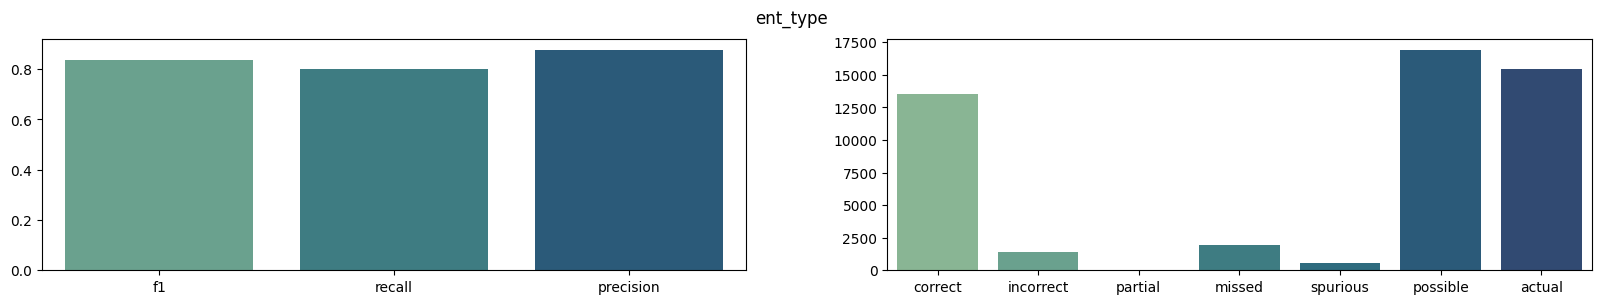

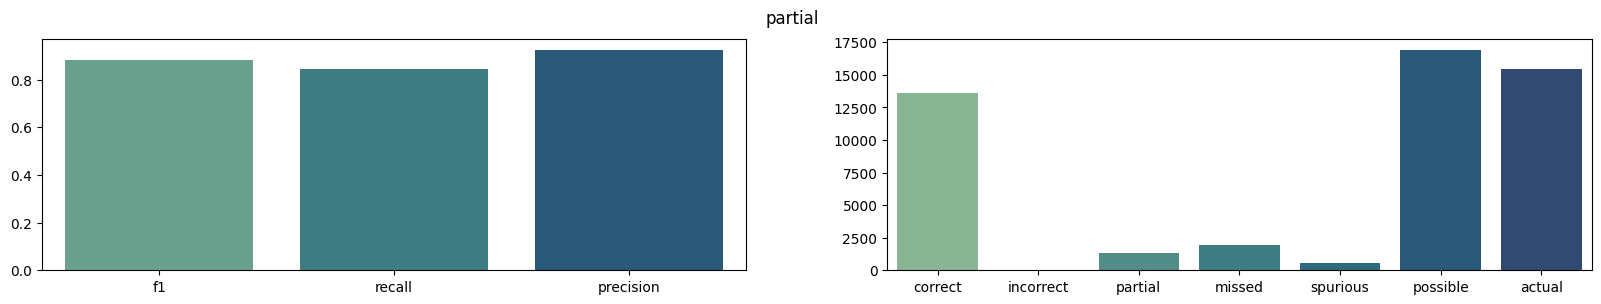

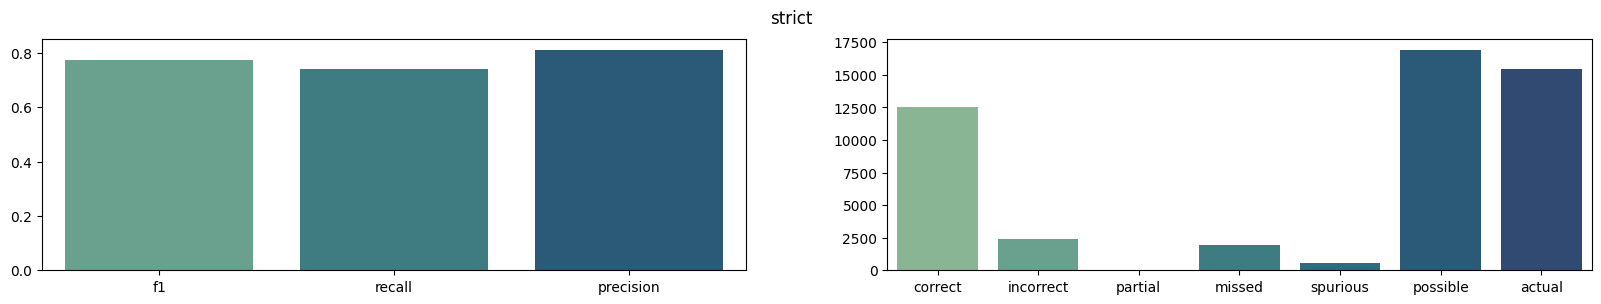

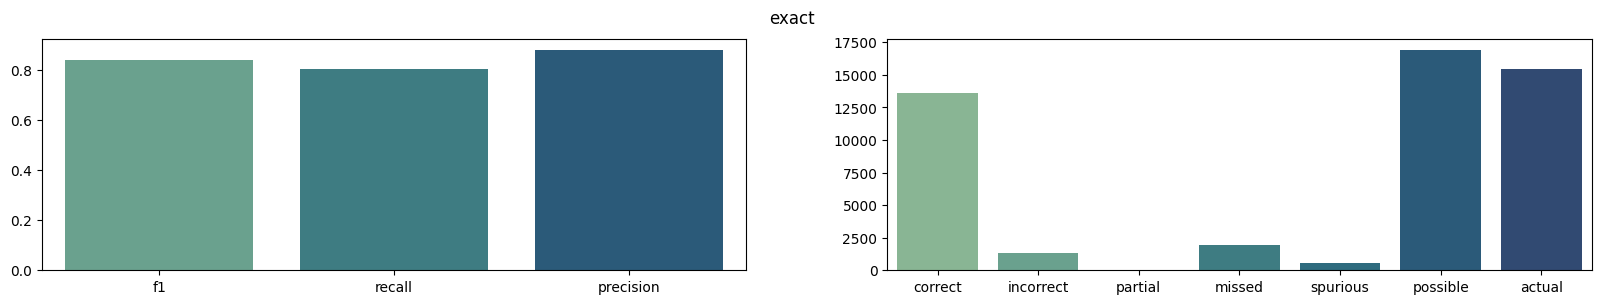

In [47]:
plot_eval_result(results)

In [56]:
!pip install hmmlearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 1.6 MB/s eta 0:00:00


In [57]:
import hmmlearn
from hmmlearn import hmm

In [58]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt  # show graph
import random

#some other libraries
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from typing import List

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, \
    f1_score, roc_auc_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [60]:
data2.head()

,Sentence #,Word,POS,Tag
0,0,Thousands,NNS,O
1,0,of,IN,O
2,0,demonstrators,NNS,O
3,0,have,VBP,O
4,0,marched,VBN,O


In [86]:
data2.rename(columns = {'Sentence #':'sentence'}, inplace = True)

In [87]:
data2.head()

,sentence,Word,POS,Tag
0,0,thousands,NNS,O
1,0,,IN,O
2,0,demonstrators,NNS,O
3,0,,VBP,O
4,0,marched,VBN,O


In [61]:
def pre_processing(text_column):
    # lowercase all text in the column
    text_column = text_column.str.lower()

    # replacing numbers with NUM token
    text_column = text_column.str.replace(r'\d+', 'NUM')

    # removing stopwords
    stop_words = set(stopwords.words('english'))
    text_column = text_column.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    return text_column

In [63]:
data_pre_precessed = pre_processing(data2.Word)

<ipython-input-61-55c14dc0c7d8>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  text_column = text_column.str.replace(r'\d+', 'NUM')


In [64]:
data_pre_precessed.head(20)


0         thousands
1                  
2     demonstrators
3                  
4           marched
5                  
6            london
7                  
8           protest
9                  
10              war
11                 
12             iraq
13                 
14           demand
15                 
16       withdrawal
17                 
18          british
19           troops
Name: Word, dtype: object

In [89]:
#creating new dataframe with preprocessed word as a column
data_processed = data2
data_processed['Word'] = data_pre_precessed

#removing the rows where word is empty
data_processed = data_processed[(data_processed['Word'] != '') | (data_processed['Word'].isna())]

In [90]:
data_processed.head(20)

,sentence,Word,POS,Tag
0,0,thousands,NNS,O
2,0,demonstrators,NNS,O
4,0,marched,VBN,O
6,0,london,NNP,B-geo
8,0,protest,VB,O
10,0,war,NN,O
12,0,iraq,NNP,B-geo
14,0,demand,VB,O
16,0,withdrawal,NN,O
18,0,british,JJ,B-gpe


In [92]:
y = data2.POS
X = data2.drop('POS', axis=1)

gs = GroupShuffleSplit(n_splits=2, test_size=.33, random_state=42)
train_ix, test_ix = next(gs.split(X, y, groups=data2['sentence']))

data_train = data2.loc[train_ix]
data_test = data2.loc[test_ix]

In [93]:
data_train.head(5)

,sentence,Word,POS,Tag
54,2,,PRP,O
55,2,marched,VBD,O
56,2,,IN,O
57,2,,DT,O
58,2,houses,NNS,O


In [94]:
data_test.head(5)

,sentence,Word,POS,Tag
0,0,thousands,NNS,O
1,0,,IN,O
2,0,demonstrators,NNS,O
3,0,,VBP,O
4,0,marched,VBN,O


In [95]:
#using preprocessed data

y1 = data_processed.POS
X1 = data_processed.drop('POS', axis=1)
data_processed.reset_index(drop=True, inplace=True)
gs = GroupShuffleSplit(n_splits=2, test_size=.33, random_state=42)
train_ix1, test_ix1 = next(gs.split(X1, y1, groups=data_processed['sentence']))

data_train1 = data_processed.loc[train_ix1]
data_test1 = data_processed.loc[test_ix1]

In [96]:
data_train1.head()

,sentence,Word,POS,Tag
33,2,marched,VBD,O
34,2,houses,NNS,O
35,2,parliament,NN,O
36,2,rally,NN,O
37,2,hyde,NNP,B-geo


In [97]:
data_test1.head()

,sentence,Word,POS,Tag
0,0,thousands,NNS,O
1,0,demonstrators,NNS,O
2,0,marched,VBN,O
3,0,london,NNP,B-geo
4,0,protest,VB,O


In [121]:
import pandas as pd

# Assuming 'data_train' is defined elsewhere
# Sample 15% of data_train and update the 'Word' column to 'UNKNOWN'
df_update = data_train.sample(frac=0.15, replace=False, random_state=42)
df_update['Word'] = 'UNKNOWN'
data_train.update(df_update)

# Get unique words and tags from the updated data_train
words = list(set(data_train['Word'].values))
tags = list(set(data_train['Tag'].values))

# Convert words into numbers
word2id = {w: i for i, w in enumerate(words)}

# Assuming 'tags' is a list of unique tag names
# Assign unique IDs to each tag
tag2id = {tag: i for i, tag in enumerate(tags)}

# Create a reverse mapping from IDs to tag names
id2tag = {i: tag for tag, i in tag2id.items()}

num_tags = len(tags)
num_words = len(words)

print(f"Number of unique tags: {num_tags}, Number of unique words: {num_words}")


Number of unique tags: 17, Number of unique words: 23632


In [125]:
def viterbi(pi: np.array, a: np.array, b: np.array, obs: List) -> np.array:
    """
     Write the viterbi algorithm from scratch to find the best probable path
     attr:
       pi: initial probabilities
       a: transition probabilities
       b: emission probabilities
       obs: list of observations
     return:
       array of the indices of the best hidden states
    """
    # state space cardinality
    K = a.shape[0]

    # observation sequence length
    T = len(obs)

    # initializing the tracking tables from first observation
    delta = np.zeros((T, K))
    psi = np.zeros((T, K))
    delta[0] = pi * b[:, obs[0]]

    # iterating throught the observations updating the tracking tables
    for t in range(1, T):
        for j in range(K):
            delta[t, j] = np.max(delta[t-1] * a[:, j] * b[j, obs[t]])
            psi[t, j] = np.argmax(delta[t-1] * a[:, j])

    # build the output, optimal model trajectory
    x = np.zeros(T, dtype=int)
    x[T-1] = np.argmax(delta[T-1])
    for t in range(T-2, -1, -1):
        x[t] = psi[t+1, x[t+1]]

    return x

In [126]:
hidden_states = ['healthy', 'sick']
observable_states = ['sleeping', 'eating', 'pooping']
observations = []
for i in range(100):
  observations.append(random.choice(observable_states))

In [127]:
import random

hidden_states = ['Sunny', 'Cloudy', 'Rainy']
observable_states = ['Hot', 'Mild', 'Cold', 'Windy', 'Foggy']
observations =  []

for i in range(40):
  obs_index = random.randint(0, len(observable_states)-1) # random index corresponding to the observable state
  observations.append(obs_index) # then adding the index to the observations list

In [130]:
hidden_state_sequence = viterbi(startprob, transmat, emissionprob, observations)

print("Observations:", observations)
print("Viterbi sequence:", hidden_state_sequence)

Observations: [0, 1, 3, 3, 4, 0, 0, 3, 0, 1, 1, 2, 2, 3, 0, 0, 1, 2, 3, 0, 2, 0, 0, 4, 0, 3, 2, 2, 1, 0, 2, 1, 4, 3, 3, 1, 4, 1, 1, 1]
Viterbi sequence: [35 40 40 40  8 33 35 40 33 12 40  8  8 40 33 35 40  8 40 33  8 33 35  833 40  8  8 40 33  8 40  8 40 40 40  8 40 40 40]


In [131]:
import numpy as np


def baum_welch(observations, observations_vocab, n_hidden_states):
    """
    Baum-Welch algorithm for estimating the HMM parameters
    :param observations: observations
    :param observations_vocab: observations vocabulary
    :param n_hidden_states: number of hidden states to estimate
    :return: a, b (transition matrix and emission matrix)
    """

    def forward_probs(observations, observations_vocab, n_hidden_states, a_, b_) -> np.array:
        """
        forward pass to calculate alpha
        :param observations: observations
        :param observations_vocab: observation vocabulary
        :param n_hidden_states: number of hidden states
        :param a_: estimated alpha
        :param b_: estimated beta
        :return: refined alpha_
        """
        a_start = 1 / n_hidden_states
        alpha_ = np.zeros((n_hidden_states, len(observations)), dtype=float)
        alpha_[:, 0] = a_start
        for t in range(1, len(observations)):
          for j in range(n_hidden_states):
            calc = observations_vocab == observations[t]
            for i in range(n_hidden_states):
              alpha_[j, t] = sum(alpha_[i, t-1]*a_[i,j] * b_[j, np.where(calc)[0][0]] for i in range(n_hidden_states))

        return alpha_

    def backward_probs(observations, observations_vocab, n_hidden_states, a_, b_) -> np.array:
        """
        backward pass to calculate alpha
        :param observations: observations
        :param observations_vocab: observation vocabulary
        :param n_hidden_states: number of hidden states
        :param a_: estimated alpha
        :param b_: estimated beta
        :return: refined beta_
        """
        beta_ = np.zeros((n_hidden_states, len(observations)), dtype=float)
        beta_[:, -1:] = 1
        for t in range(len(observations) -2, -1, -1):
          for i in range(n_hidden_states):
            calc2 = observations_vocab == observations[t+1]
            beta_[i,t] = sum(a_[i,j] * b_[j, np.where(calc2)[0][0]]*beta_[j, t+1] for j in range(n_hidden_states))
        return beta_

    def compute_gamma(alfa, beta, observations, vocab, n_samples, a_, b_) -> np.array:
        """

        :param alfa:
        :param beta:
        :param observations:
        :param vocab:
        :param n_samples:
        :param a_:
        :param b_:
        :return:
        """
        # gamma_prob = np.zeros(n_samples, len(observations))
        gamma_prob = np.multiply(alfa, beta) / sum(np.multiply(alfa, beta))
        return gamma_prob

    def compute_sigma(alfa, beta, observations, vocab, n_samples, a_, b_) -> np.array:
        """

        :param alfa:
        :param beta:
        :param observations:
        :param vocab:
        :param n_samples:
        :param a_:
        :param b_:
        :return:
        """
        sigma_prob = np.zeros((n_samples, len(observations) - 1, n_samples), dtype=float)
        denomenator = np.multiply(alfa, beta)
        for i in range(len(observations) - 1):
            for j in range(n_samples):
                for k in range(n_samples):
                    index_in_vocab = np.where(vocab == observations[i + 1])[0][0]
                    sigma_prob[j, i, k] = (alfa[j, i] * beta[k, i + 1] * a_[j, k] * b_[k, index_in_vocab]) / sum(                        denomenator[:, j])
        return sigma_prob

    # initialize A ,B
    a = np.ones((n_hidden_states, n_hidden_states)) / n_hidden_states
    b = np.ones((n_hidden_states, len(observations_vocab))) / len(observations_vocab)
    for iter in tqdm(range(2000), position=0, leave=True):

        # E-step caclculating sigma and gamma
        alfa_prob = forward_probs(observations, observations_vocab, n_hidden_states, a, b)  #
        beta_prob = backward_probs(observations, observations_vocab, n_hidden_states, a, b)  # , beta_val
        gamma_prob = compute_gamma(alfa_prob, beta_prob, observations, observations_vocab, n_hidden_states, a, b)
        sigma_prob = compute_sigma(alfa_prob, beta_prob, observations, observations_vocab, n_hidden_states, a, b)

        # M-step caclculating A, B matrices
        a_model = np.zeros((n_hidden_states, n_hidden_states))
        for j in range(n_hidden_states):  # calculate A-model
            for i in range(n_hidden_states):
                for t in range(len(observations) - 1):
                    a_model[j, i] = a_model[j, i] + sigma_prob[j, t, i]
                normalize_a = [sigma_prob[j, t_current, i_current] for t_current in range(len(observations) - 1) for
                               i_current in range(n_hidden_states)]
                normalize_a = sum(normalize_a)
                if normalize_a == 0:
                    a_model[j, i] = 0
                else:
                    a_model[j, i] = a_model[j, i] / normalize_a

        b_model = np.zeros((n_hidden_states, len(observations_vocab)))

        for j in range(n_hidden_states):
            for i in range(len(observations_vocab)):
                indices = [idx for idx, val in enumerate(observations) if val == observations_vocab[i]]
                numerator_b = sum(gamma_prob[j, indices])
                denominator_b = sum(gamma_prob[j, :])
                if denominator_b == 0:
                    b_model[j, i] = 0
                else:
                    b_model[j, i] = numerator_b / denominator_b

        a = a_model
        b = b_model
    return a, b


import random

hidden_states = ['healthy', 'sick']
observable_states = ['sleeping', 'eating', 'pooping']
observable_map = {'sleeping': 0, 'eating': 1, 'pooping': 2}
observations = []
for i in range(40):
    observations.append(observable_map[random.choice(observable_states)])

A, B = baum_welch(observations=observations, observations_vocab=np.array(list(observable_map.values())),
                  n_hidden_states=2)


100%|██████████| 2000/2000 [00:10<00:00, 197.32it/s]


In [132]:
hidden_state_sequence = viterbi(startprob, transmat, emissionprob, observations)

print("Observations:", observations)
print("Viterbi sequence:", hidden_state_sequence)

Observations: [1, 1, 1, 0, 2, 2, 0, 2, 2, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 0, 2]
Viterbi sequence: [12 40 40 33  8  8 33  8  8 33 40 33  8 40  8  8  8  8  8 33 35 40 33  8
 40 40 40  8 40  8  8 40  8 40 40  8 40 40 33  8]
